Load dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yashdevladdha/uber-ride-analytics-dashboard")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'uber-ride-analytics-dashboard' dataset.
Path to dataset files: /kaggle/input/uber-ride-analytics-dashboard


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer

In [3]:
df=pd.read_csv(os.path.join(path, "ncr_ride_bookings.csv"))

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = pd.to_datetime(df['Time']).dt.time

df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce').dt.hour
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Weekday'] = df['Date'].dt.weekday


/tmp/ipython-input-142589243.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time']).dt.time


In [5]:
df.isna().sum()

,0
Date,0
Time,0
Booking ID,0
Booking Status,0
Customer ID,0
Vehicle Type,0
Pickup Location,0
Drop Location,0
Avg VTAT,10500
Avg CTAT,48000


Identify Which Missing Values Are NORMAL

| Column                                | Why NaN is *normal*                                   |
| ------------------------------------- | ----------------------------------------------------- |
| **Payment Method**                    | If ride cancelled → no payment                        |
| **Avg CTAT**                          | If no ride completion → no CTAT                       |
| **Avg VTAT**                          | If no driver allocated → no VTAT                      |
| **Cancelled Rides by Customer**       | If not cancelled by customer → 0 or NaN is acceptable |
| **Cancelled Rides by Driver**         | Same logic                                            |
| **Incomplete Rides**                  | Only exists for incomplete bookings                   |
| **Reason for cancelling by Customer** | Only exists when customer cancels                     |
| **Driver Cancellation Reason**        | Only exists when driver cancels                       |
| **Incomplete Rides Reason**           | Only exists when ride is incomplete                   |


Columns that MUST be filled

| Column          | Why fill?                                               |
| --------------- | ------------------------------------------------------- |
| Booking Value   | Needed for regression models / fraud / revenue analysis |
| Ride Distance   | Critical for prediction, clustering, forecasting        |
| Driver Ratings  | Used in classification models                           |
| Customer Rating | Influences driver assignment, behavior                  |


Plot Histograms + KDE (best for seeing shape)

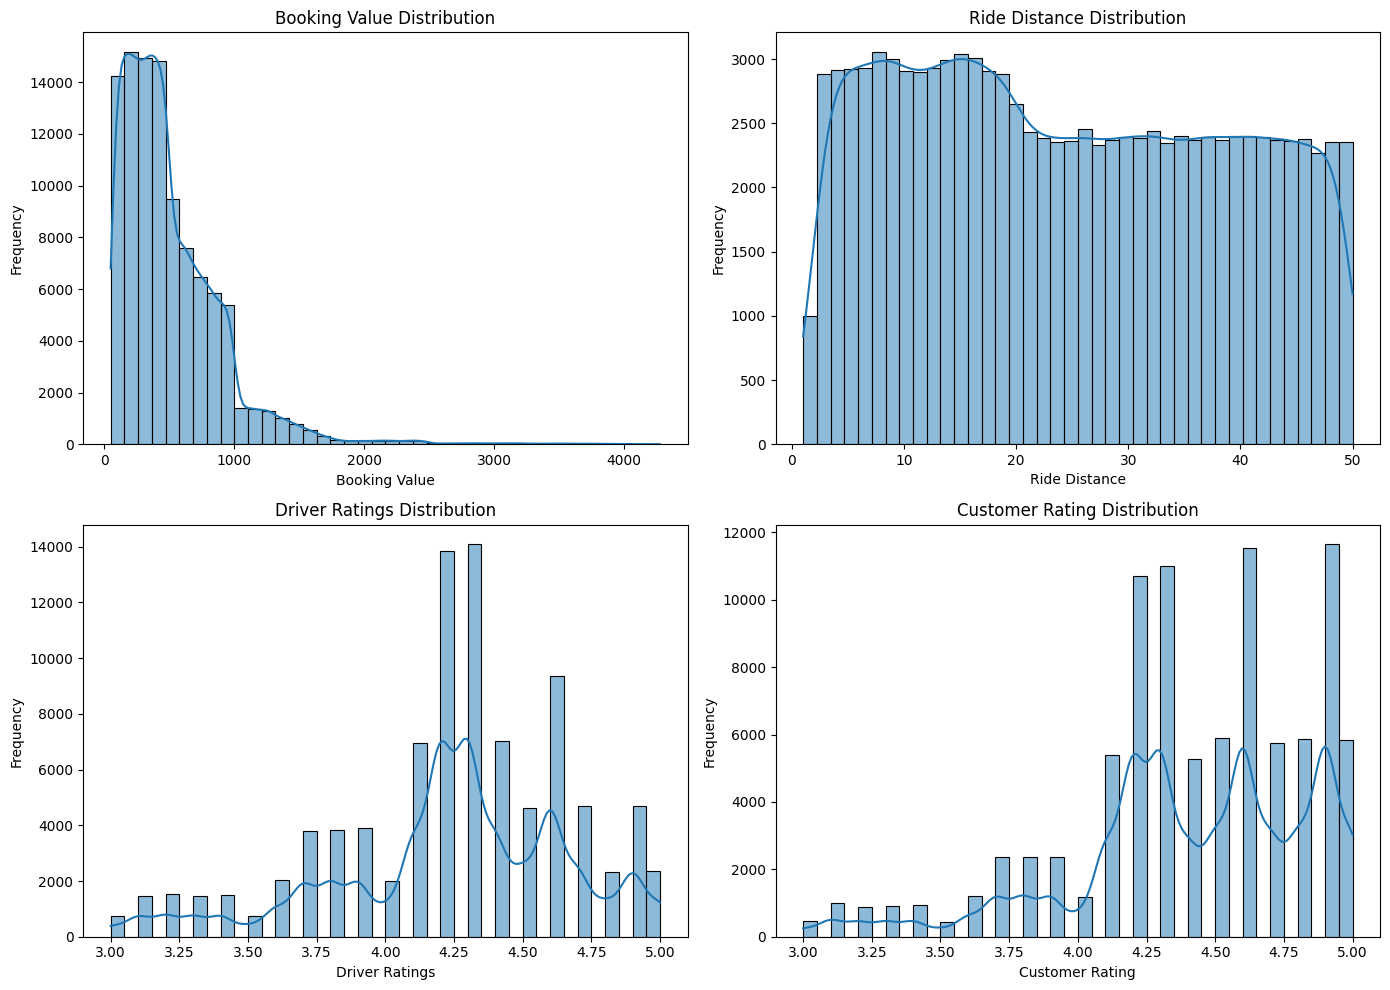

In [6]:

cols = ['Booking Value','Ride Distance','Driver Ratings','Customer Rating']

plt.figure(figsize=(14,10))

for i, col in enumerate(cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True, bins=40)
    plt.title(f'{col} Distribution')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


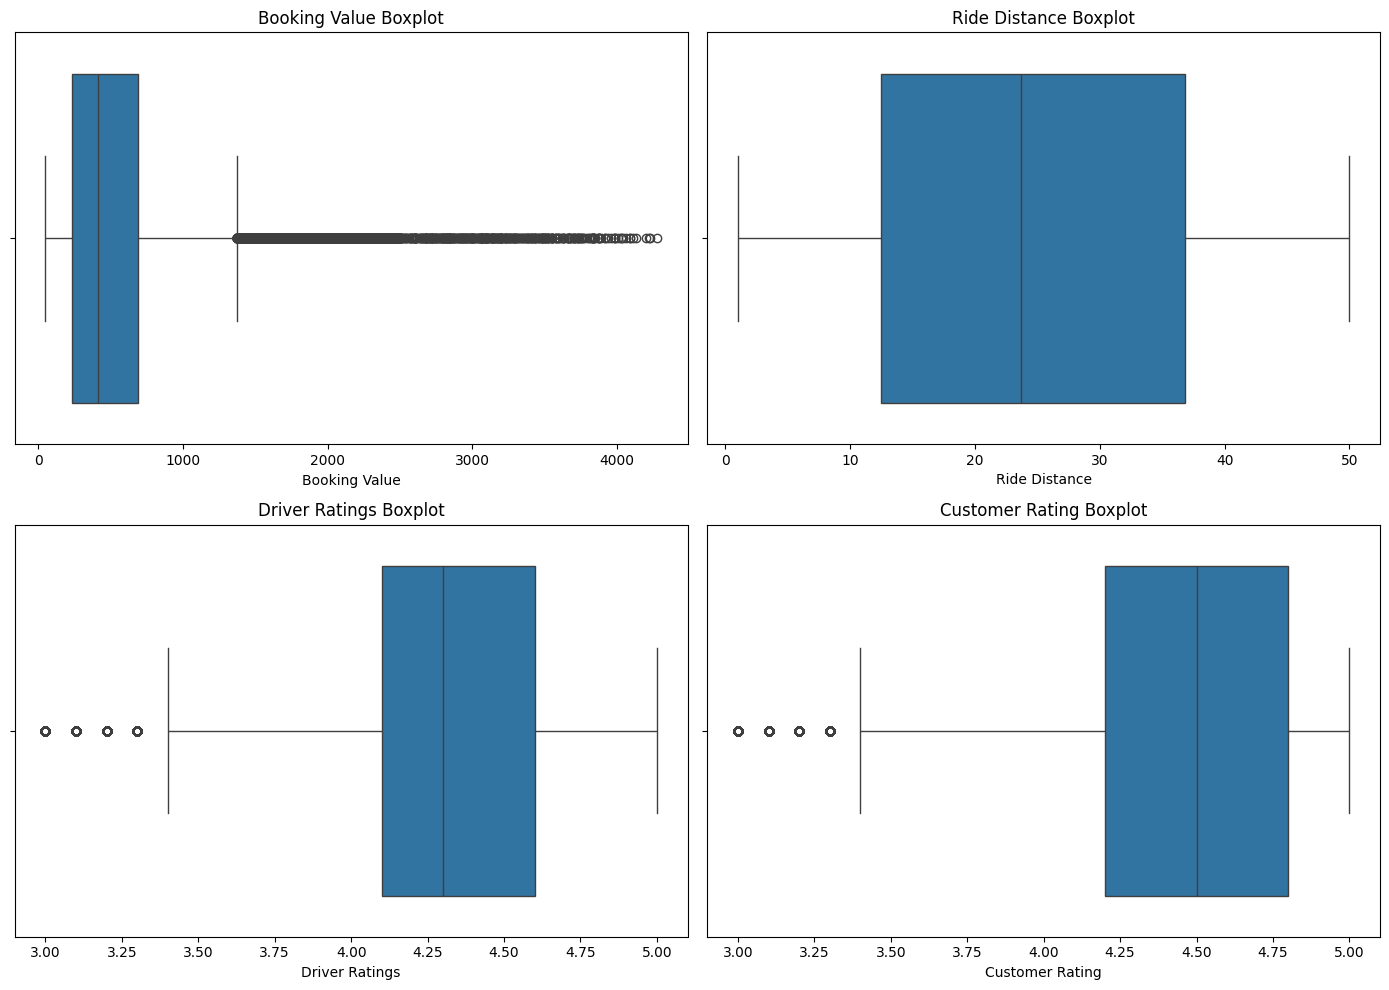

In [7]:
plt.figure(figsize=(14,10))

for i, col in enumerate(cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df[col])
    plt.title(f'{col} Boxplot')

plt.tight_layout()
plt.show()


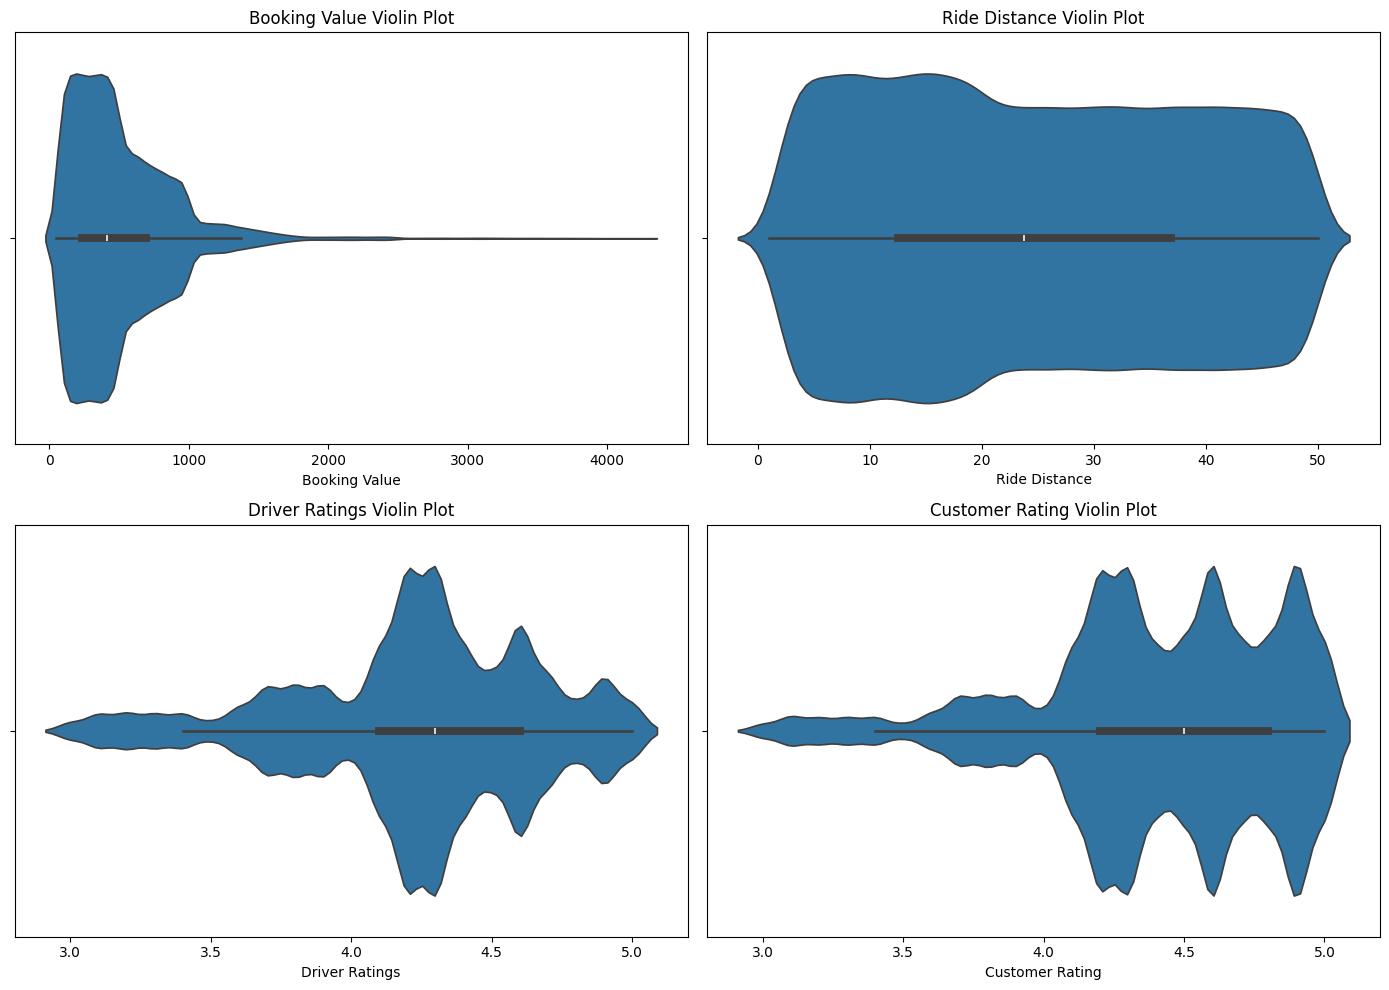

In [8]:
plt.figure(figsize=(14,10))

for i, col in enumerate(cols, 1):
    plt.subplot(2, 2, i)
    sns.violinplot(x=df[col])
    plt.title(f'{col} Violin Plot')

plt.tight_layout()
plt.show()


1 — Booking Value
✔ Observed from your plots:

Extremely right-skewed

Long heavy tail up to 4000+

Huge number of outliers

Strong peak around 100–600

✔ KNN Imputer

Because Booking Value strongly depends on:

Ride Distance

Vehicle Type

Hour of day

Location

2 — Ride Distance
✔ Observed:

Also skewed, but less extreme than booking value

Range 0 → 50 km

Boxplot shows very tolerable outliers

Shape is roughly uniform/moderate skew

✔ KNN Imputer → BEST

Because distance correlates strongly with:

Booking Value

Pickup/Drop location pair

Vehicle type

3 — Driver Ratings
✔ Observed:

Almost all values between 4.0 – 5.0

Clear clustering around 4.25–4.75

Perfectly shaped for median

Outliers very few

✔ Median → PERFECT

Ratings are ordinal

Median preserves distribution

4 — Customer Rating
✔ Observed:

Same pattern as driver rating

Ratings highly concentrated in 4–5 range

Many identical peaks (discrete behavior)

✔ Median → BEST

Simple, realistic, stable.

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

# 1 — KNN for Booking Value + Ride Distance
knn_cols = ['Booking Value','Ride Distance']

scaler = StandardScaler()
scaled = scaler.fit_transform(df[knn_cols])

imputer = KNNImputer(n_neighbors=5)
scaled_imputed = imputer.fit_transform(scaled)

df[knn_cols] = scaler.inverse_transform(scaled_imputed)

# 2 — Median for Ratings
df['Driver Ratings'] = df['Driver Ratings'].fillna(df['Driver Ratings'].median())
df['Customer Rating'] = df['Customer Rating'].fillna(df['Customer Rating'].median())


In [10]:
# 1 — Missing indicator columns
indicator_cols = [
    'Payment Method', 'Avg CTAT', 'Avg VTAT',
    'Cancelled Rides by Customer', 'Cancelled Rides by Driver',
    'Incomplete Rides',
    'Reason for cancelling by Customer', 'Driver Cancellation Reason',
    'Incomplete Rides Reason'
]

for col in indicator_cols:
    df[col + '_missing'] = df[col].isna().astype(int)

# 2 — Only fill count-based columns
df['Cancelled Rides by Customer'] = df['Cancelled Rides by Customer'].fillna(0)
df['Cancelled Rides by Driver'] = df['Cancelled Rides by Driver'].fillna(0)
df['Incomplete Rides'] = df['Incomplete Rides'].fillna(0)


In [11]:
cat_missing_cols = [
    'Payment Method',
    'Reason for cancelling by Customer',
    'Driver Cancellation Reason',
    'Incomplete Rides Reason'
]

for col in cat_missing_cols:
    df[col] = df[col].fillna('none')

df['Avg CTAT'] = df['Avg CTAT'].fillna(-1)
df['Avg VTAT'] = df['Avg VTAT'].fillna(-1)


In [12]:
df.isna().sum()

,0
Date,0
Time,0
Booking ID,0
Booking Status,0
Customer ID,0
Vehicle Type,0
Pickup Location,0
Drop Location,0
Avg VTAT,0
Avg CTAT,0


In [13]:
cat_cols = df.select_dtypes(include='object').columns

for col in cat_cols:
    print(f"\n===== {col} =====")
    print(df[col].value_counts(dropna=False))



===== Time =====
Time
17:44:57    16
19:17:33    12
17:54:33    11
11:29:50    11
10:23:23    11
            ..
14:31:44     1
01:50:30     1
16:17:05     1
04:15:42     1
20:26:18     1
Name: count, Length: 62910, dtype: int64

===== Booking ID =====
Booking ID
"CNR6337479"    3
"CNR7199036"    3
"CNR3648267"    3
"CNR2726142"    3
"CNR5292943"    3
               ..
"CNR7686931"    1
"CNR8314394"    1
"CNR1224369"    1
"CNR7115617"    1
"CNR1632634"    1
Name: count, Length: 148767, dtype: int64

===== Booking Status =====
Booking Status
Completed                93000
Cancelled by Driver      27000
No Driver Found          10500
Cancelled by Customer    10500
Incomplete                9000
Name: count, dtype: int64

===== Customer ID =====
Customer ID
"CID6715450"    3
"CID5481002"    3
"CID4523979"    3
"CID6468528"    3
"CID8727691"    3
               ..
"CID7454593"    1
"CID6137945"    1
"CID5532610"    1
"CID4521238"    1
"CID6034767"    1
Name: count, Length: 148788, dtype: i

In [14]:
df.dtypes

,0
Date,datetime64[ns]
Time,object
Booking ID,object
Booking Status,object
Customer ID,object
Vehicle Type,object
Pickup Location,object
Drop Location,object
Avg VTAT,float64
Avg CTAT,float64


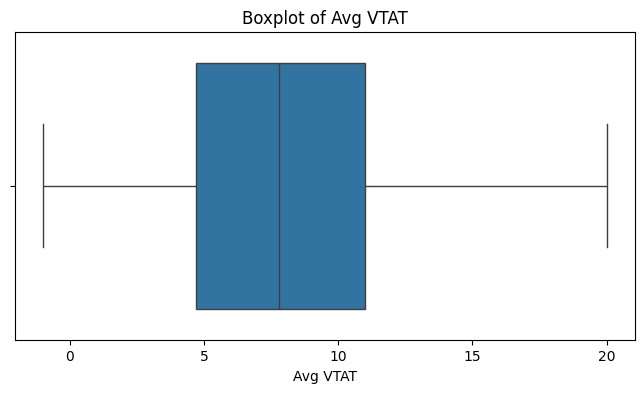

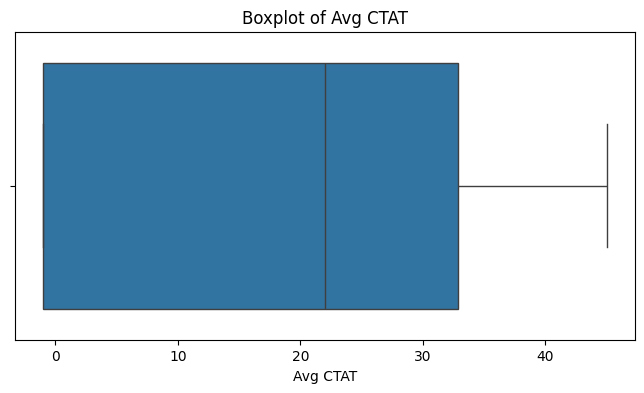

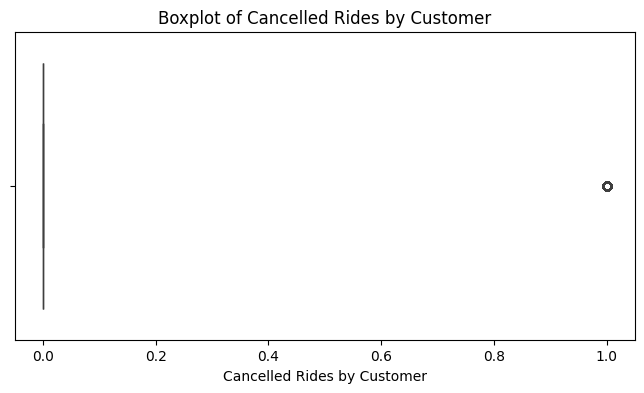

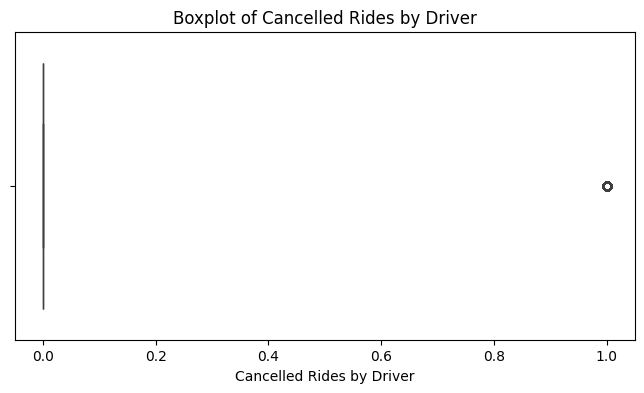

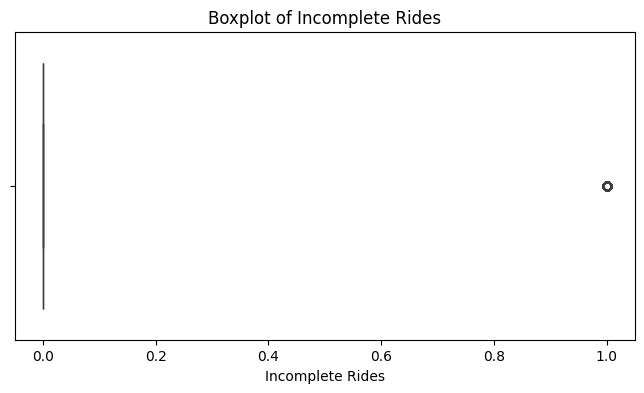

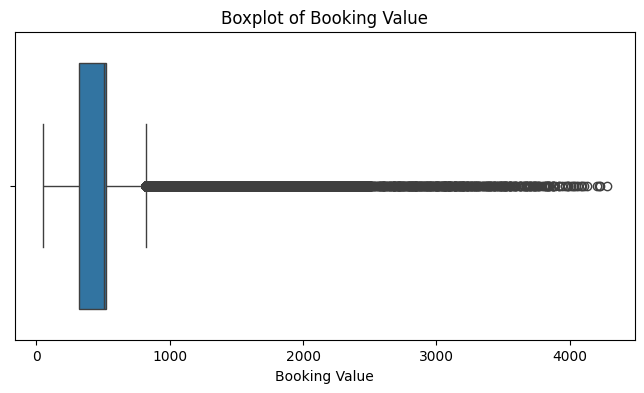

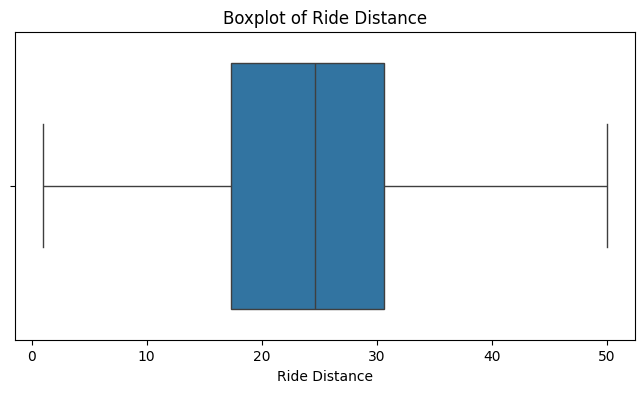

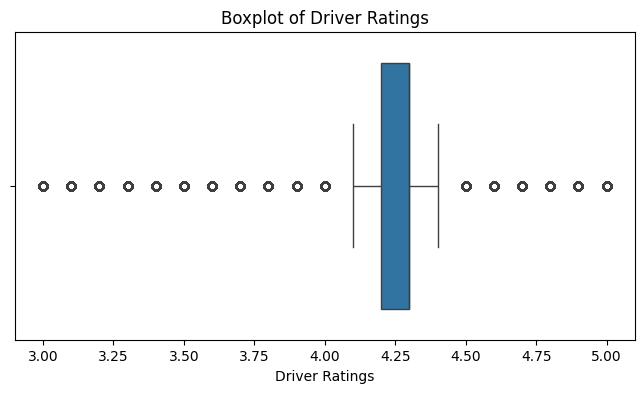

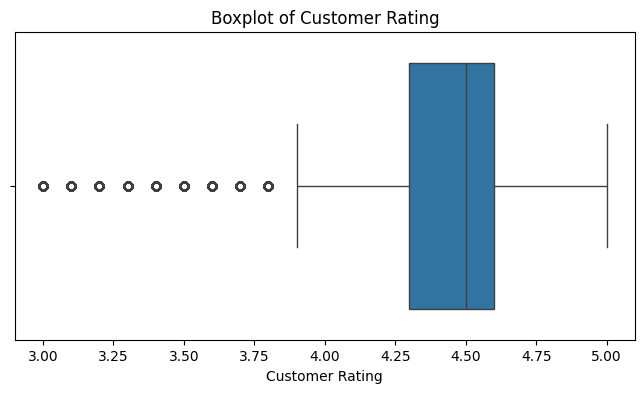

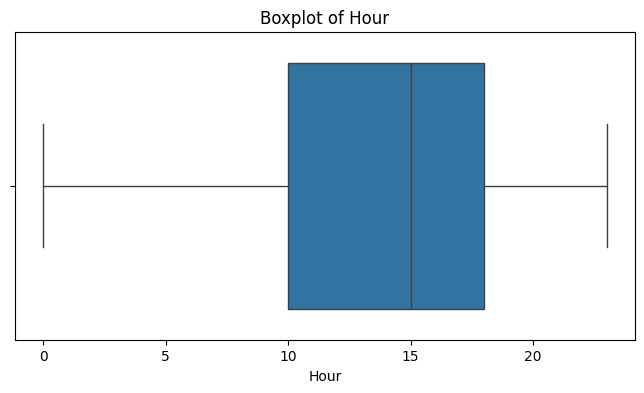

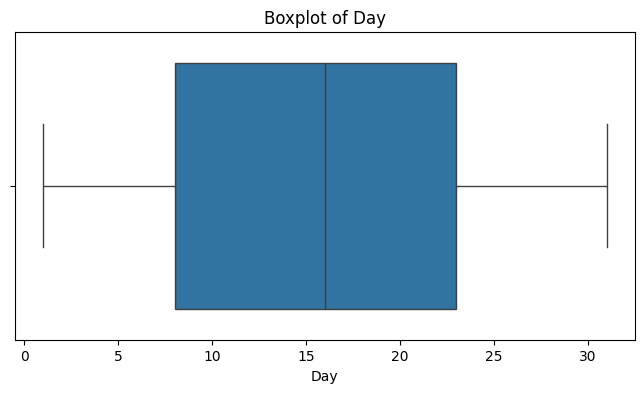

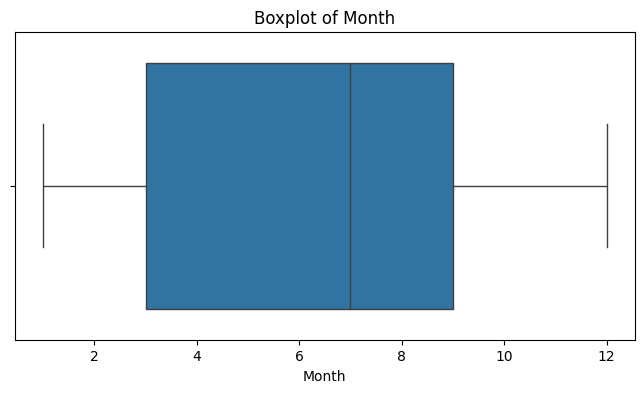

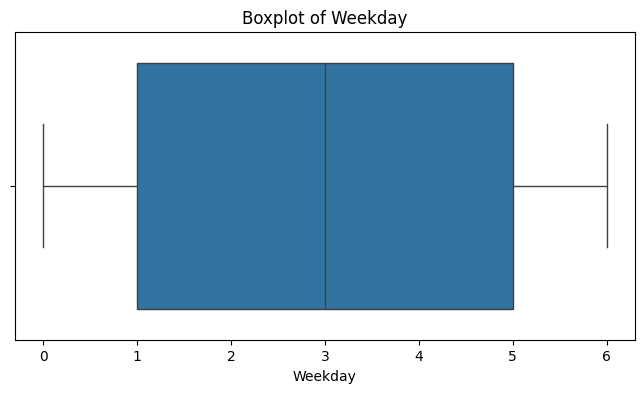

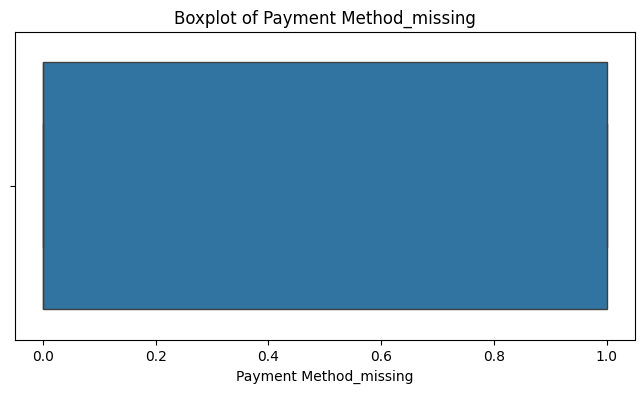

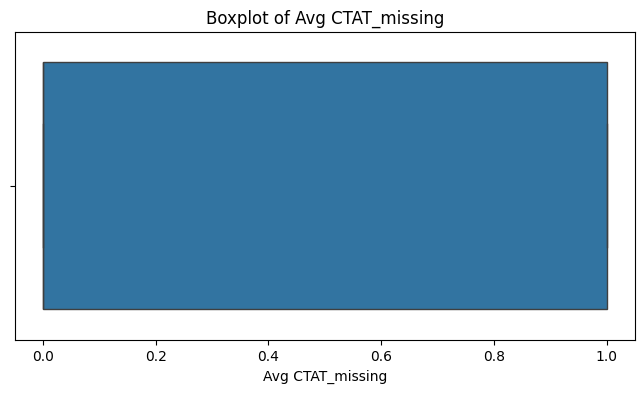

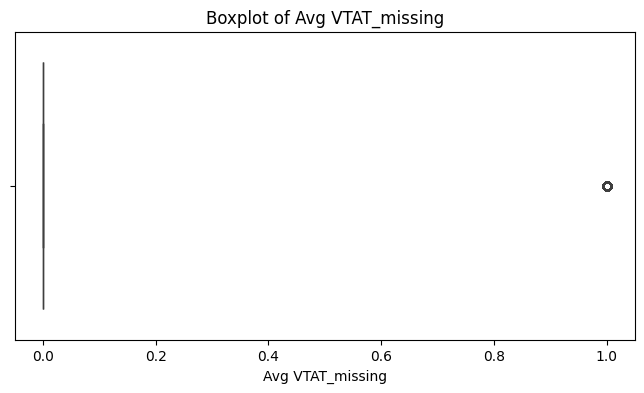

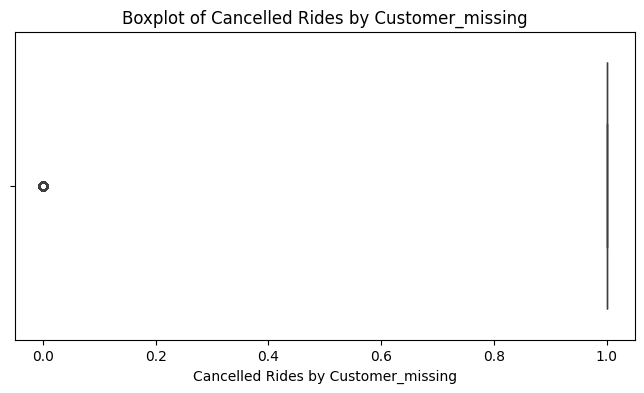

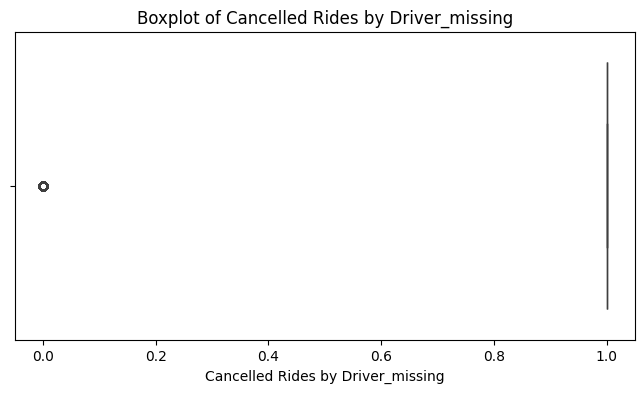

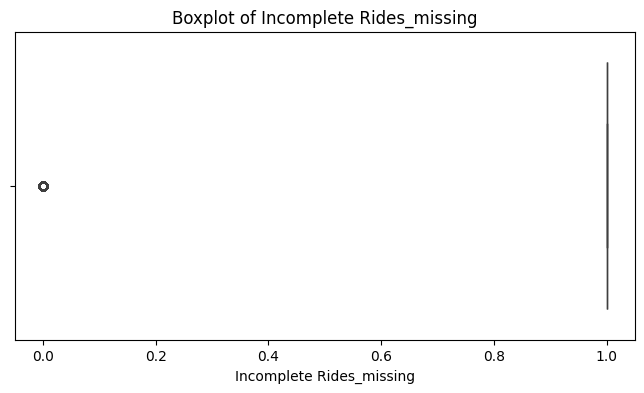

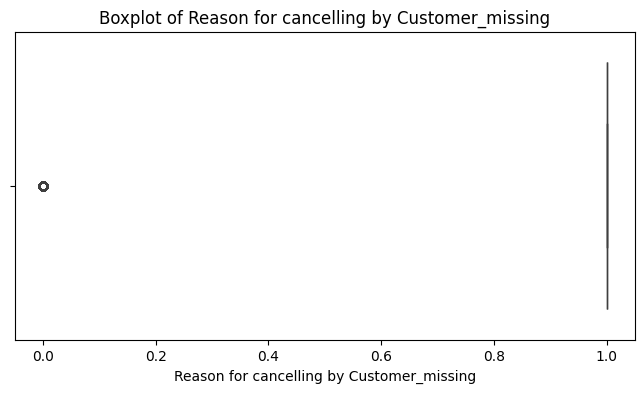

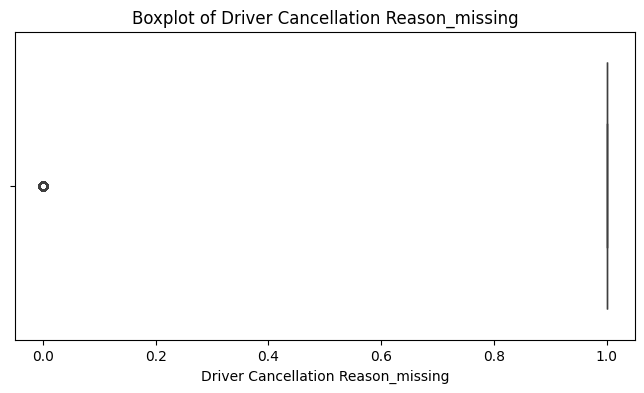

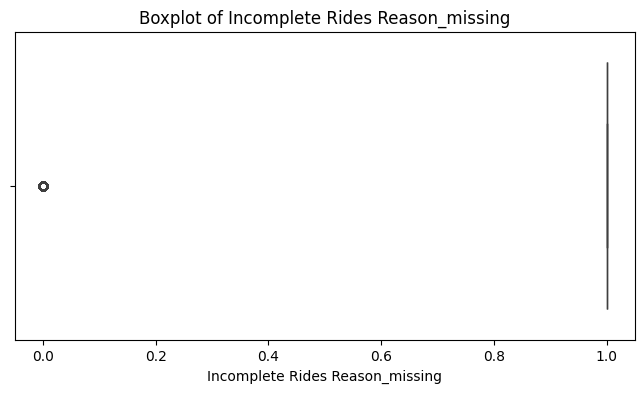

In [15]:

numeric_cols = df.select_dtypes(include=['int32','int64', 'float64']).columns

for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


| Feature                  | Boxplot Outliers       | Real? or Noise? | What to do |
| ------------------------ | ---------------------- | --------------- | ---------- |
| Booking Value            | High fares (1000–4000) | **REAL**        | Keep       |
| Booking Value            | < 5                    | **NOISE**       | Remove     |
| Driver Ratings           | 3.0–4.0 values         | **REAL**        | Keep       |
| Customer Rating          | 3.0–4.0 values         | **REAL**        | Keep       |
| Ratings < 1 or > 5       | **NOISE**              | Remove          |            |
| Distance < 0 or > 100 km | **NOISE**              | Remove          |            |


In [ ]:
df.shape

remove noise

In [19]:
def clean_outliers(df):
    # Booking Value noise
    df = df[df['Booking Value'] >= 5]

    # Rating logical boundaries
    df = df[(df['Driver Ratings'].between(1, 5))]
    df = df[(df['Customer Rating'].between(1, 5))]

    # Distance logical boundaries
    df = df[df['Ride Distance'].between(0, 100)]

    return df.reset_index(drop=True)

df = clean_outliers(df)


In [21]:
df.shape

(150000, 34)

In [24]:
df[df['Booking Value'] < 5]
df[(df['Driver Ratings'] < 1) | (df['Driver Ratings'] > 5)]
df[(df['Customer Rating'] < 1) | (df['Customer Rating'] > 5)]
df[(df['Ride Distance'] < 0) | (df['Ride Distance'] > 100)]

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,...,Weekday,Payment Method_missing,Avg CTAT_missing,Avg VTAT_missing,Cancelled Rides by Customer_missing,Cancelled Rides by Driver_missing,Incomplete Rides_missing,Reason for cancelling by Customer_missing,Driver Cancellation Reason_missing,Incomplete Rides Reason_missing


In [25]:
df.to_csv("uber_cleaned.csv", index=False)